# WoS dataset characterization

In [59]:
import jsonlines
import numpy as np
from collections import Counter, OrderedDict, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import gensim.downloader
import torch
from transformers import AutoModel, AutoTokenizer
import os, csv
from functools import reduce
import numpy as np
import umap
from sklearn.cluster import HDBSCAN

## Read in the dataset

In [2]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_ALL_15Dec2023.jsonl') as reader:
    full_main = []
    for obj in reader:
        full_main.append(obj)

## Initial characterization

### Documents without abstracts
#### Main references

In [3]:
no_abstr = []
no_abstr_years = []
for doc in full_main:
    try:
        doc['abstract']
    except KeyError:
        no_abstr.append(doc['UID'])
        try:
            no_abstr_years.append(doc['year'])
        except KeyError:
            no_abstr_years.append(np.nan)
print(f'There are {len(full_main)} documents in the main search results, and {len(no_abstr)} of these are missing abstracts')

There are 6903 documents in the main search results, and 375 of these are missing abstracts


Is there a pattern to the documents missing abstracts in terms of what year they were published?

Text(0.5, 1.0, 'Publication years of papers without abstracts in main search results')

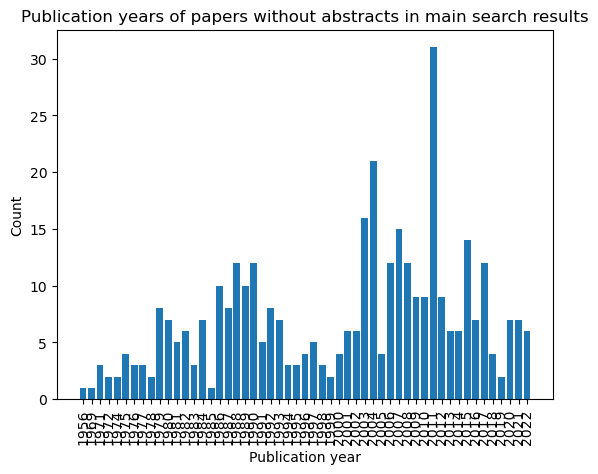

In [4]:
counted_years = OrderedDict(sorted(Counter(no_abstr_years).items()))
plt.bar(counted_years.keys(), counted_years.values())
_ = plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Count')
plt.title('Publication years of papers without abstracts in main search results')

There is no clear pattern of publication year.

### Reference characterization
#### Number of references per paper

In [5]:
num_refs = [len(doc['references']) for doc in full_main]
counted_refs = OrderedDict(sorted(Counter(num_refs).items()))
print(f'The papers in the search results have a mean of {sum(num_refs)/len(num_refs):.2f} references.')

The papers in the search results have a mean of 54.31 references.


Text(0.5, 1.0, 'Number of references per paper in dataset')

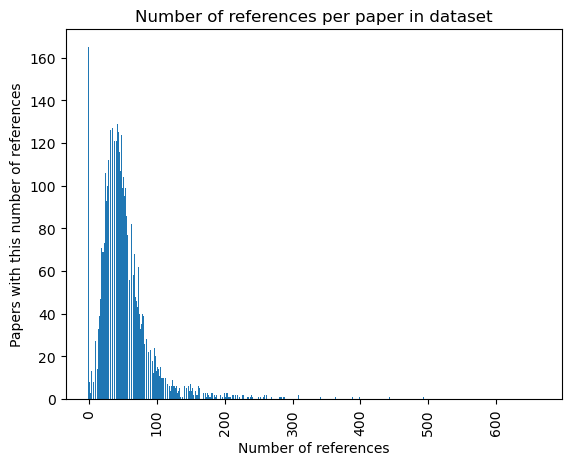

In [6]:
plt.bar(counted_refs.keys(), counted_refs.values())
_ = plt.xticks(rotation=90)
plt.xlabel('Number of references')
plt.ylabel('Papers with this number of references')
plt.title('Number of references per paper in dataset')

There are a surprising number of papers with no references -- what's up there?

In [7]:
no_refs = [doc for doc in full_main if len(doc['references']) == 0]
print(f'There are {len(no_refs)} papers with no references in the dataset.')

There are 165 papers with no references in the dataset.


Do these overlap with the papers that have no abstract?

In [8]:
no_refs_and_no_abstract = [doc for doc in no_refs if doc['UID'] in no_abstr]
print(f'{len(no_refs_and_no_abstract)} of the papers with no references also have no abstract.')

132 of the papers with no references also have no abstract.


That is a high proportion, which makes sense and will be dropped from the dataset. What about the remaining 32 papers with no references? Let's pull a sample of their UIDs and manually check them; it's possible they actually have no references.

In [9]:
no_refs_but_abstract = [doc['UID'] for doc in no_refs if doc['UID'] not in no_abstr]
no_refs_but_abstract[:5]

['WOS:A1992JF38800001',
 'WOS:A1995RQ10400016',
 'WOS:A1991GG65200007',
 'WOS:A1992KD98900008',
 'WOS:A1992JQ67100004']

`WOS:A1992JF38800001` has references but they only exist in the scanned PDF. `WOS:A1995RQ10400016` has no version linked on WoS. `WOS:A1991GG65200007` has a PDF with references, same with `WOS:A1992KD98900008`. These four are all from the early 90's; what does the year distribution look like for these papers?

Text(0.5, 1.0, 'Publication years of papers without references but that have abstracts')

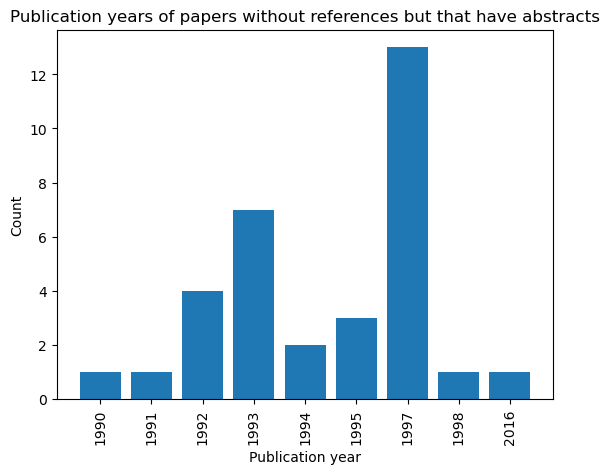

In [10]:
years_for_no_refs = [doc['year'] for doc in no_refs if doc['UID'] not in no_abstr]
counted_no_ref_years = OrderedDict(sorted(Counter(years_for_no_refs).items()))
plt.bar(counted_no_ref_years.keys(), counted_no_ref_years.values())
_ = plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Count')
plt.title('Publication years of papers without references but that have abstracts')

They're all from the 90s with the exception of the one paper from 2016. Not sure what's going on there; may want to reach out to figure out if there's something funky going on.

####  Proportion of references not in Core Colection for main search results
The documentation states: "There are two types of uid values: 1) the UID of a matching source item in Web of Science and 2) the UID of the parent (citing) document, followed by an increment. A value of the second type indicates a reference for which there is no matching source item." However, it is unclear to me if the references of the second type are prefixed by `WOS:` or not; it seems like they are not, and are just numbers, but also in some cases do have the `WOS` prefix. I've included both below.

In [11]:
no_core_props = []
no_uid_entries = []
total_refs = 0
for doc in full_main:
    UID = doc['UID']
    total_paper_refs = len(doc['references'])
    not_in_core = 0
    for ref in doc['references']:
        try:
            if (ref['UID'].split('.')[0] == UID) or (ref['UID'].split('.')[0] == UID.split(':')[1]):
                try:
                    assert len(ref['UID'].split('.')) == 2
                    not_in_core += 1
                except AssertionError:
                    print(doc['UID'], ref['UID'])
        except KeyError:
            no_uid_entries.append(ref)
    try:
        no_core_props.append(not_in_core/total_paper_refs)
    except ZeroDivisionError:
        no_core_props.append(0)
    total_refs += total_paper_refs
print(f'There are {total_refs} references in the dataset as a whole.')

WOS:000625084200001 WOS:000625084200001
WOS:000623923100001 WOS:000623923100001
WOS:000615278100031 WOS:000615278100031
WOS:000708492600002 WOS:000708492600002
There are 374909 references in the dataset as a whole.


Four references have an identical UID to the parent paper, without the numerical addition at the end to state the order in which the paper was referenced. However, that is actually quite spectatular given that there are 374,909 total references. Let's quickly take a look at the references for one of the papers with the UID identical to parent and see if we can figure out what's going on there.

Text(0, 0.5, 'Count')

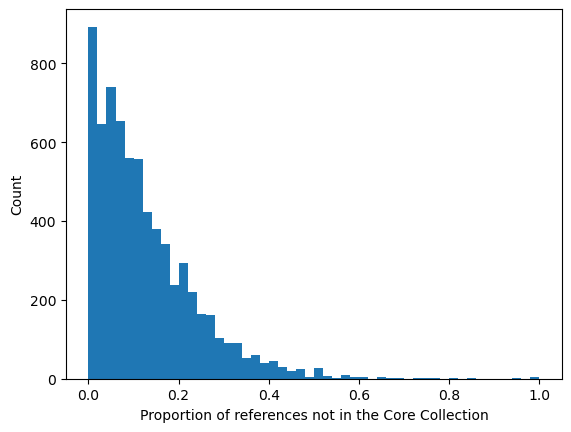

In [12]:
_ = plt.hist(no_core_props, bins=50)
plt.xlabel('Proportion of references not in the Core Collection')
plt.ylabel('Count')

In [13]:
print(f'{Counter(no_core_props)[0]} of {len(no_core_props)} papers have all references included in the Core Collection, which is {(Counter(no_core_props)[0]/len(no_core_props))*100:.2f} percent of references.')

632 of 6903 papers have all references included in the Core Collection, which is 9.16 percent of references.


Unfortunately, very few papers have all of their references exclusively in the Core Collection. This is not necessarily surprising, as WoS Core Collection is intended to prioritize quality over coverage; but does potentially pose some issues for the assumption that anything outside the Core Collection can be dropped.

#### Number of references without a year
This looks for references that didn't have a year recorded where they were referenced; however, it may be possible to ameliorate some of this when we go back and look for the paper abstracts.

In [14]:
refs_no_year = 0
for doc in full_main:
    for ref in doc['references']:
        try:
            ref['year']
        except KeyError:
            refs_no_year += 1

In [15]:
print(f'{refs_no_year} of {total_refs} total references are missing a year, which is {(refs_no_year/total_refs)*100:.2f} percent of references.')

527 of 374909 total references are missing a year, which is 0.14 percent of references.


Not bad at all! I also don't really use the year for much, so I am totally comfortable with this number.

#### Number of references without a title
It came to my attention whey trying to run `descriptive_stats.py` that not all references have a title. Which references are those?

In [16]:
no_title = [ref for doc in full_main for ref in doc['references'] if 'title' not in ref.keys()]

In [17]:
print(f'{len(no_title)} of {total_refs} have no title, which is {(len(no_title)/total_refs)*100:.2f} percent of references.')

29730 of 374909 have no title, which is 7.93 percent of references.


That is quite a lot of abstracts with no title. I wonder if they're mainly abstracts outside the Core Collection?

In [18]:
no_title_uids = []
no_uids_no_title = []
for ref in no_title:
    try:
        no_title_uids.append(ref['UID'])
    except KeyError:
        no_uids_no_title.append(ref)

In [19]:
print(f'There are {len(no_title_uids)} references that have no title but do have a UID, and there are {len(no_uids_no_title)} references with neither.')

There are 29721 references that have no title but do have a UID, and there are 9 references with neither.


In [20]:
not_in_core_no_title = [UID for UID in no_title_uids if len(UID.split('.')) == 2]

In [21]:
print(f'{len(not_in_core_no_title)} of {len(no_title_uids)} title-less abstracts are not in the Core Collection, which is {(len(not_in_core_no_title)/len(no_title_uids))*100:.2f} percent of the title-less references.')

29714 of 29721 title-less abstracts are not in the Core Collection, which is 99.98 percent of the title-less references.


This is a good thing if we decide to drop these, since they'll almost all go.

### Static keyword characterization
Before progressing to the more complex dynamic keywords, let's characterize the static keywords in this dataset to see if they may be useful for exclusion.
#### Number of unique static keywords per paper

In [22]:
num_static = []
for doc in full_main:
    num_static.append(len(set(doc['static_keywords'])))

Text(0, 0.5, 'Paper count')

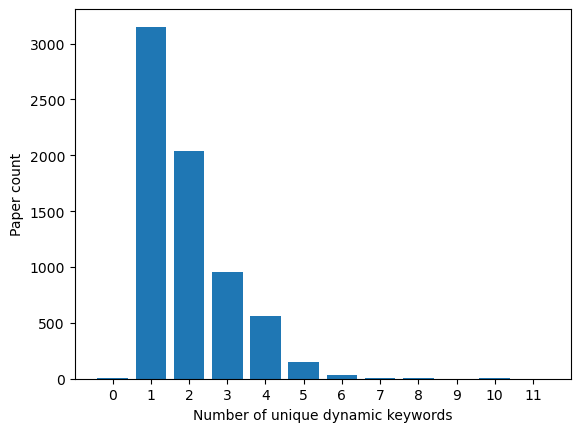

In [23]:
counted_static = OrderedDict(sorted(Counter(num_static).items()))
plt.bar([str(k) for k in counted_static.keys()], counted_static.values())
plt.xlabel('Number of unique dynamic keywords')
plt.ylabel('Paper count')

#### Frequency of static keywords in dataset

In [24]:
all_static_keys = [stat for doc in full_main for stat in doc['static_keywords']]

In [25]:
print(f'There are {len(set(all_static_keys))} unique static keywords in the dataset.')

There are 148 unique static keywords in the dataset.


In [26]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate_from_frequencies(Counter(all_static_keys))

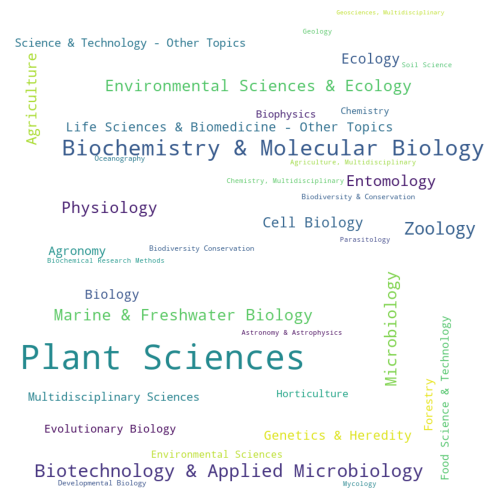

In [27]:
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

How many times do these keywords tend to appear in the dataset, and which are the low-frequency ones?

Text(0, 0.5, 'Count')

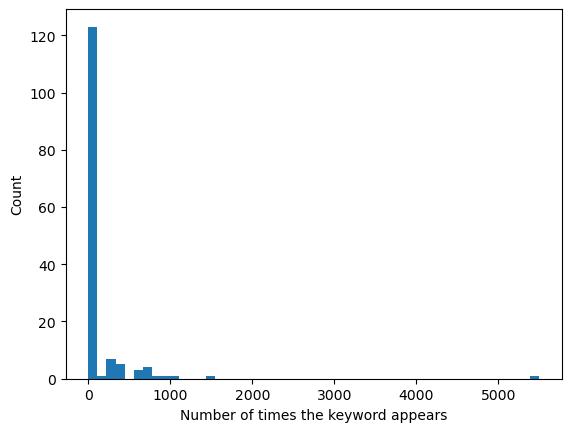

In [28]:
_ = plt.hist(Counter(all_static_keys).values(), bins=50)
plt.xlabel('Number of times the keyword appears')
plt.ylabel('Count')

In [29]:
low_freq_static = [k for k, v in Counter(all_static_keys).items() if v < 50]

In [30]:
low_freq_static[:20]

['Medicine, Research & Experimental',
 'Research & Experimental Medicine',
 'Fisheries',
 'Chemistry, Organic',
 'Polymer Science',
 'Nutrition & Dietetics',
 'Agricultural Engineering',
 'Meteorology & Atmospheric Sciences',
 'Chemistry, Medicinal',
 'Materials Science, Ceramics',
 'Materials Science, Multidisciplinary',
 'Materials Science',
 'Immunology',
 'Geography, Physical',
 'Physical Geography',
 'Medical Laboratory Technology',
 'Limnology',
 'Nanoscience & Nanotechnology',
 'Physics, Applied',
 'Physics, Condensed Matter']

I think the static keywords show a lot of promise for exclusion criteria, as some of these are clearly out of scope; however, we should still explore the dynamic keywords.

## Dynamic keyword characterization
Now let's take a look at the dynamic keywords we've retreived with our dataset to see if they show more promise for exclusion than the static ones.

### Number of papers containing dynamic keywords

In [31]:
papers_w_dynamics = []
for doc in full_main:
    try:
        papers_w_dynamics.append(doc['dynamic_keys'])
    except KeyError:
        continue
print(f'{len(papers_w_dynamics)} of {len(full_main)} papers have dynamic keywords.')

6903 of 6903 papers have dynamic keywords.


### Number of unique dynamic keywords per paper

In [32]:
num_dynamos = []
for doc in full_main:
    num_dynamos.append(len(set(doc['dynamic_keys'])))

Text(0, 0.5, 'Paper count')

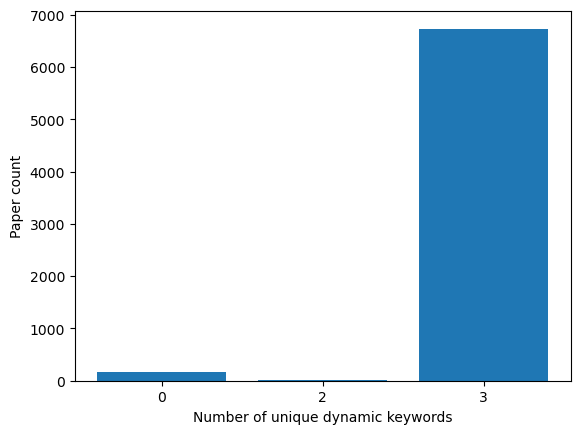

In [33]:
counted_dynamos = OrderedDict(sorted(Counter(num_dynamos).items()))
plt.bar([str(k) for k in counted_dynamos.keys()], counted_dynamos.values())
plt.xlabel('Number of unique dynamic keywords')
plt.ylabel('Paper count')

#### Frequency of dynamic keywords in dataset
Nearly all papers have 3 keywords, some have none. Let's take a look at what the common keywords are with a wordcloud.

In [34]:
all_dynamo_keys = [dynamo for doc in full_main for dynamo in doc['dynamic_keys']]

In [35]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate_from_frequencies(Counter(all_dynamo_keys))

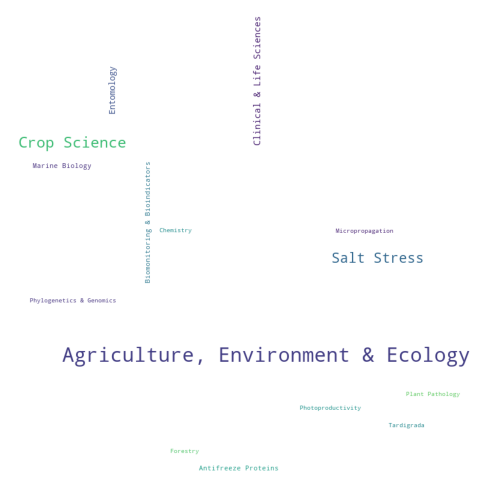

In [36]:
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

This wordcloud is definitely missing things; there are likely a lot of keywords that only appear once or a few times. Let's take a look by plotting the distribution of how many times a keyword appears:

Text(0, 0.5, 'Count')

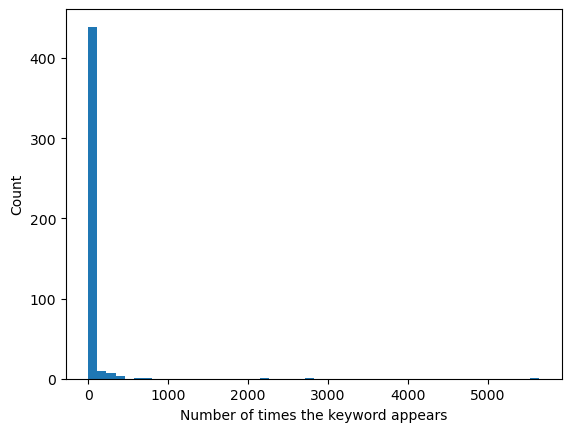

In [37]:
_ = plt.hist(Counter(all_dynamo_keys).values(), bins=50)
plt.xlabel('Number of times the keyword appears')
plt.ylabel('Count')

In [38]:
print(f'There are {len(set(all_dynamo_keys))} total unique dynamic keywords.')

There are 464 total unique dynamic keywords.


As with the static keywords, most keywords only appear a few times. This makes a rule-based exclusion system sort of challenging, because there are a lot of rare words. Let's try using an embedding method to get a sense of the semantic distribution of these keywords.

### Number of tokens in dynamic keywords
Here we'll assume that the keywords break cleanly on spaces, and remove punctuation.

In [39]:
punc = '.!,&;:'
num_toks = [len([tok for tok in k.split() if tok not in punc]) for k in set(all_dynamo_keys)]

Text(0, 0.5, 'Count')

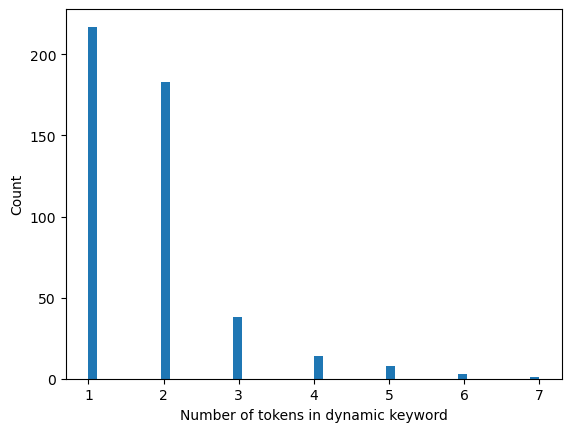

In [40]:
_ = plt.hist(num_toks, bins=50)
plt.xlabel('Number of tokens in dynamic keyword')
plt.ylabel('Count')

About half of the keywords only have a single token, but they can have up to 7. What do the higher token number keywords look like?

In [41]:
higher_num_keys = [k for k in set(all_dynamo_keys) if len([tok for tok in k.split() if tok not in punc]) > 3]

In [42]:
higher_num_keys

['Molecular & Cell Biology - Mitochondria',
 'Inflammatory Bowel Diseases & Infections',
 'Molecular & Cell Biology - Genetics',
 'Protein Stucture, Folding & Modelling',
 'Molecular & Cell Biology - Pharmacology',
 'Herbicides, Pesticides & Ground Poisoning',
 'Molecular & Cell Biology - Cancer & Development',
 'Oceanography, Meteorology & Atmospheric Sciences',
 'Nitroxides, Antioxidants & Free Radicals',
 'Molecular & Cell Biology - Immunotherapy',
 'Virology - Tropical Diseases',
 'Molecular & Cell Biology - DNA Damage',
 'Paper & Wood Materials Science',
 'Parasitology - Malaria, Toxoplasmosis & Coccidiosis',
 'Molecular & Cell Biology - Cancer, Autophagy & Apoptosis',
 'Molecular & Cell Biology - Physiology',
 'Electrical Engineering, Electronics & Computer Science',
 'Sleep Science & Circadian Systems',
 'Ionic, Molecular & Complex Liquids',
 'Extracellular Matrix & Cell Differentiation',
 'Advanced Glycation End Products',
 'Micro & Long Noncoding RNA',
 'Biophotonics & Electro

These look very much like journal categories, and are very broad. Could we exclude these? Let's take a look at the shorter keywords for comparison.

In [43]:
lower_num_keys = [k for k in set(all_dynamo_keys) if len([tok for tok in k.split() if tok not in punc]) <= 3]

In [44]:
lower_num_keys[:20]

['Integrins',
 'Forest Fires',
 'Thioredoxin',
 'Animal Sensing',
 'Formicidae',
 'Stratum Corneum',
 'Juvenile Hormone',
 'Neuroscanning',
 'Microtubules',
 'Stable Isotopes',
 'Microbial Fuel Cell',
 'Grazing Crops',
 'Microbial Biomass',
 'Rangelands',
 'Triterpenoids',
 'Alpha-Tocopherol',
 'Sports Science',
 'Mesoporous Silica',
 'Cell Biology',
 'Glacier']

Some of these are very specific, others are not. However, I could potentially manually classify these keywords into relevant/not relevant, and see if splitting the documents along those lines yields high performance.

## Keyword classification approaches
We want to come up with some way to determine which keywords are relevant and which ones aren't, in order to decide what to keep. We can try a few methods to do this, the simplest of which is manually classifying keywords and using those classifications to separate the dataset.

### Word embeddings for keyword characterization
Before manually classifying the keywords, let's see if there's a more high-throughput way to determine what keywords should stay or go. To do this, we'll explore using word embeddings, and clustering them by meaning to see if we can exclude/include certain clusters.

In most basic implementations, we only use unigrams, so let's see how many of the static and dynamic keywords are unigrams.

In [45]:
num_uni_dynamo_keys = [str(len([kw for kw in doc['dynamic_keys'] if len([tok for tok in kw.split() if tok not in punc]) == 1])) for doc in full_main]
num_uni_static_keys = [str(len([kw for kw in doc['static_keywords'] if len([tok for tok in kw.split() if tok not in punc]) == 1])) for doc in full_main]

Text(0, 0.5, 'Count')

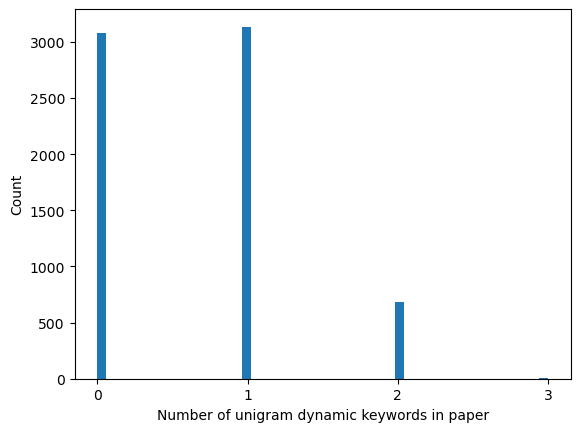

In [46]:
_ = plt.hist(num_uni_dynamo_keys, bins=50)
plt.xlabel('Number of unigram dynamic keywords in paper')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

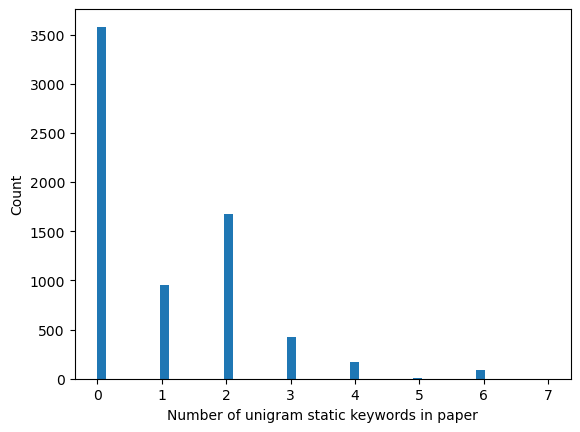

In [47]:
_ = plt.hist(sorted(num_uni_static_keys), bins=50)
plt.xlabel('Number of unigram static keywords in paper')
plt.ylabel('Count')

Almost half of papers don't have any unigram keywords of either type, so only considering those keywords will not be sufficient. However, for the sake of simplicity, we'll perform this embedding analysis on only unigram keywords; if it proves to be useful, we can expand it to include all ngrams.

In [48]:
uni_dynamo_keys = set([kw for doc in full_main for kw in doc['dynamic_keys'] if len([tok for tok in kw.split() if tok not in punc]) == 1])
uni_static_keys = set([kw for doc in full_main for kw in doc['static_keywords'] if len([tok for tok in kw.split() if tok not in punc]) == 1])
print(f'There are {len(uni_dynamo_keys)} unique dynamic unigram keys, and {len(uni_static_keys)} unique static unigram keys.')

There are 217 unique dynamic unigram keys, and 42 unique static unigram keys.


##### Pretrained context-free embeddings
The most straightforward approach to getting embeddings for a list of words without context is to use a pretrained word2vec or GloVe embedding model. However, a lot of our keywords are scientific words, which may mean they don't exist in a pretrained model, and it is much harder to get a meaningful embedding for out-of-vocabulary words in a word2vec or GloVe model. Let's check a GloVe model to get an idea of how bad the situation is:

In [49]:
pretrained_vecs = gensim.downloader.load('glove-wiki-gigaword-300')

In [50]:
has_glove_dynamo = [True if kw in pretrained_vecs.index_to_key else False for kw in uni_dynamo_keys]
has_glove_static = [True if kw in pretrained_vecs.index_to_key else False for kw in uni_static_keys]
print(f'{Counter(has_glove_dynamo)[True]} of {len(has_glove_dynamo)} total dynamic keywords have glove embeddings.')
print(f'{Counter(has_glove_static)[True]} of {len(has_glove_static)} total static keywords have glove embeddings.')

0 of 217 total dynamic keywords have glove embeddings.
0 of 42 total static keywords have glove embeddings.


Not great. One simpler option here would be to train a model using the full text of the titles and abstracts; however, it's likely that most keywords don't appear in their parent texts. Let's quantify that assumption:

In [51]:
keyword_in_text_dynamo = defaultdict(list)
keyword_in_text_static = defaultdict(list)
for doc in full_main:
    try:
        text = doc['title'] + doc['abstract']
    except KeyError:
        text = doc['title']
    for keyword in doc['dynamic_keys']:
        if keyword in uni_dynamo_keys:
            if keyword in text:
                keyword_in_text_dynamo[keyword].append(True)
            else:
                keyword_in_text_dynamo[keyword].append(False)
    for keyword in doc['static_keywords']:
        if keyword in uni_static_keys:
            if keyword in text:
                keyword_in_text_static[keyword].append(True)
            else:
                keyword_in_text_static[keyword].append(False)
keyword_in_text_dynamo = {k: list(set(v)) for k, v in keyword_in_text_dynamo.items()}
keyword_in_text_static = {k: list(set(v)) for k, v in keyword_in_text_static.items()}

In [52]:
for kind, group in {'dynamic': keyword_in_text_dynamo, 'static': keyword_in_text_static}.items():
    in_text = [k for k, v in group.items() if v == [True]]
    not_in_text = [k for k, v in group.items() if v == [False]]
    both = [k for k, v in group.items() if len(v) == 2]
    print(f'Of the total of {len(group)} {kind} keywords, {len(in_text)} are always in the text of their documents, '
         f'{len(not_in_text)} are never in the text of their documents, and {len(both)} are sometimes in the text.')

Of the total of 217 dynamic keywords, 20 are always in the text of their documents, 157 are never in the text of their documents, and 40 are sometimes in the text.
Of the total of 42 static keywords, 0 are always in the text of their documents, 33 are never in the text of their documents, and 9 are sometimes in the text.


Also not a good look for that idea! We could append the words somewhere in the text, but I don't know that that would actually give us meaningful context from which to generate embeddings for those words.

##### Contextualized embeddings with SciBERT
Another option is to use a BERT model, which can generate embeddings based on subwords for words that are out of vocabulary. I'll follow [this tutorial](https://medium.com/mlearning-ai/getting-contextualized-word-embeddings-with-bert-20798d8b43a4) for generating word embeddings (code from notebook available [here](https://colab.research.google.com/drive/1ea3zDFrCQFQhkvinaQfdbvXlOhR7hw01?usp=sharing#scrollTo=l5GKOZx7Xo4M)). Typically, the advantage of using BERT is that it can account for varying context for words; however, here we don't have contexts for out keywords. While the lack of context could prove limiting for this analysis, I think it is still worthwhile to try it. Since these are scientific keywords, I'll use SciBERT, which is likely to have more keywords in vocabulary.

In [53]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased', output_hidden_states=True)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensor

In [55]:
def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens, in context of the given sentence.
    """
    # gradient calculation id disabled
    with torch.no_grad():
        # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]

    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)

    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)

    # intialized list to store embeddings
    token_vecs_sum = []

    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence

    # loop over tokens in sentence
    for token in token_embeddings:

        # "token" is a [12 x 768] tensor

        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)

    return token_vecs_sum

In the below function, I am altering the code from the tutorial to simply average the embeddings for all the subwords, since these are just keywords and not sentences.

In [56]:
def embed_keywords(key_list):
    """
    Embed a list of keywords.
    """
    context_embeddings = []
    context_tokens = []
    for keyword in key_list:
        tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(keyword, tokenizer)
        list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
        averaged_embedding = torch.div(reduce(torch.add, list_token_embeddings), len(list_token_embeddings))
        context_tokens.append(keyword)
        context_embeddings.append(averaged_embedding)
        
    return context_tokens, context_embeddings

In [57]:
dynamo_context_tokens, dynamo_context_embeddings = embed_keywords(uni_dynamo_keys)

In [58]:
static_context_tokens, static_context_embeddings = embed_keywords(uni_static_keys)

##### Clustering the word vectors
While t-SNE (which we can visualize on TensorBoard) produce visualizations that show clusters, it is not actually a clustering algorithm; it's a dimension reduction algorithm like PCA. You cannot rely on the clusters of t-SNE to be real, as explained [here](https://stats.stackexchange.com/a/264647). So instead, we'll use another method for getting the clusters to which our keywords belong.

###### UMAP-HDBSCAN
The clustering algorithm used in [BERTopic](https://arxiv.org/pdf/2203.05794.pdf) is HDBSCAN on UMAP-reduced data. I'm going to start with this approach because, while BERTopic uses full document embeddings, word embeddings are similar, and the authors of BERTopic demonstrated that UMAP-HDBSCAN was the best approach for data with that dimensionality.

In [60]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(dynamo_context_embeddings)
embedding.shape

(217, 2)

Text(0.5, 1.0, 'UMAP reduction of dynamic keyword embeddings')

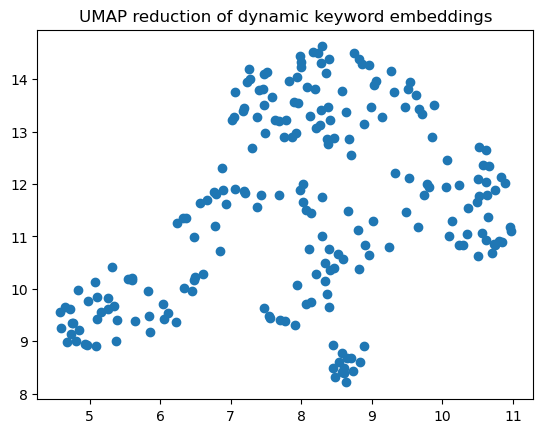

In [62]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.title('UMAP reduction of dynamic keyword embeddings')

In [64]:
hdb = HDBSCAN()
hdb.fit(embedding)

HDBSCAN()

In [67]:
colors = {
    -1: 'blue',
    0: 'red',
    1: 'green',
    2: 'purple',
    3: 'orange',
    4: 'yellow',
    5: 'brown',
    6: 'black'
}

Text(0.5, 1.0, 'HDSCAN clustering on UMAP reduction of dynamic keyword embeddings')

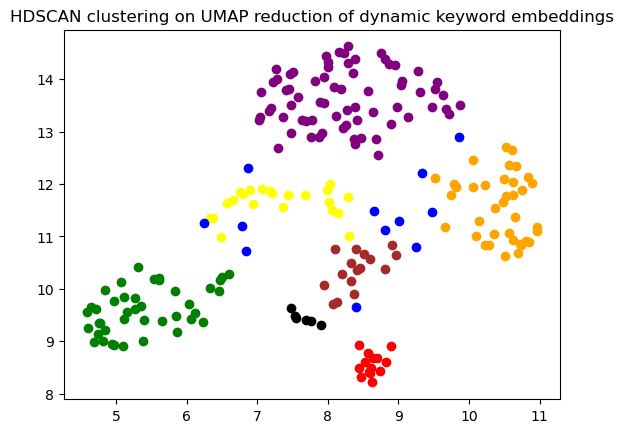

In [75]:
fig, ax = plt.subplots(1, 1)
for elt, label in zip(embedding, hdb.labels_):
    ax.scatter(elt[0], elt[1], color=colors[label])
plt.title('HDSCAN clustering on UMAP reduction of dynamic keyword embeddings')

Hey that looks pretty good! The blue points are those designated as noise by the algorithm; I imagine a fair way to treat those points would be to manually classify each of them (as opposed to the entire cluster). Let's take a closer look at what words cluster together, and generalize about the groupings.

###### Cluster generalizations

In [77]:
dynamo_cluster_membership = pd.DataFrame({'keyword': dynamo_context_tokens, 'cluster': hdb.labels_})

In [79]:
dynamo_cluster_membership[dynamo_cluster_membership['cluster'] == 0]

,keyword,cluster
13,Chalcones,0
27,Triterpenoids,0
33,Mycotoxins,0
56,Microcystins,0
76,Nitroxides,0
94,Andrographolide,0
125,Carotenoids,0
128,Polyamines,0
131,Gangliosides,0
160,Micronuclei,0


Looks like cluster 0 is chemical names.

In [80]:
dynamo_cluster_membership[dynamo_cluster_membership['cluster'] == 1]

,keyword,cluster
7,Formicidae,1
8,Lizards,1
9,Acanthamoeba,1
12,Holocene,1
22,Foraminifera,1
26,Rangelands,1
31,Permafrost,1
37,Glacier,1
51,Paramecium,1
53,Microalgae,1


Cluster 1 is scientific and common organism names.

In [81]:
dynamo_cluster_membership[dynamo_cluster_membership['cluster'] == 2]

,keyword,cluster
0,Groundwater,2
1,Integrins,2
5,Ophthalmology,2
6,Robotics,2
11,Resveratrol,2
...,...,...
208,Firmness,2
210,Metformin,2
212,Apoptosis,2
213,Synthesis,2


This cluster doesn't have a clear theme, and is also the largest.

In [82]:
dynamo_cluster_membership[dynamo_cluster_membership['cluster'] == 3]

,keyword,cluster
2,Metabolomics,3
10,Neuroscanning,3
15,Micropropagation,3
19,Biodiesel,3
30,Bioaerosols,3
41,Peroxisomes,3
42,Entomology,3
44,Biodeterioration,3
45,Evapotranspiration,3
47,Electroporation,3


Cluster 3 is disciplines and methods.

In [83]:
dynamo_cluster_membership[dynamo_cluster_membership['cluster'] == 4]

,keyword,cluster
18,Struvite,4
23,MPPT,4
29,Paraquat,4
35,PGPR,4
38,Anura,4
46,FOXP3,4
68,STEC,4
73,Aquaporin,4
79,Ferns,4
80,Nodulation,4


These look like protein names mostly.

In [84]:
dynamo_cluster_membership[dynamo_cluster_membership['cluster'] == 5]

,keyword,cluster
3,Beta-Lactoglobulin,5
4,Thioredoxin,5
14,Inulinase,5
21,Phytochrome,5
74,Aerenchyma,5
100,Phosphofructokinase,5
103,Laccase,5
116,Bacteriophage,5
122,Hydroxyapatite,5
127,Cellulase,5


These are also protein and compound names.

In [85]:
dynamo_cluster_membership[dynamo_cluster_membership['cluster'] == 6]

,keyword,cluster
24,Perchlorate,6
59,Dimethylsulfoniopropionate,6
65,Trimetazidine,6
151,Acrylamide,6
162,Thiamine,6
191,Atrazine,6


These are also compound names.

In [87]:
dynamo_cluster_membership[dynamo_cluster_membership['cluster'] == -1]

,keyword,cluster
28,Alpha-Tocopherol,-1
52,Bioluminescence,-1
87,RNA-Seq,-1
133,Gossypol,-1
135,Photoproductivity,-1
145,Microsatellites,-1
166,Haemoproteus,-1
181,lncRNA,-1
184,Tardigrada,-1
189,Rumen,-1


I can certainly see which clusters I would have assigned these to, but overall I think it's reasoable that they were excluded as noise.

###### 

The clusters themes are:
* 0: Compound classes
* 1: Organism names (both scientific and common)
* 2: Doesn't have a clear group semantic, is also the largest cluster
* 3: Disciplines and methods
* 4: Proteins and compounds
* 5: Proteins and compounds
* 6: Compounds

I have to say that this worked spectacularly well from the viewpoint of actually clustering similar keywords; the fact that all clusters but one have basically spot on groupings (i.e. there is a clear theme that can be identified by looking at the member words) is impressive to me. However, it's clear that this method won't work for deciding what papers to keep or throw, because of the nature of the keywords themselves; for example, the disciplines gorup together, but we'll want to keep some disciplines and throw others. I expect the same to happen with the static keywords, but I'd like to perform the same analysis for the sake of thoroughness.

In [88]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(static_context_embeddings)
embedding.shape

(42, 2)

Text(0.5, 1.0, 'UMAP reduction of static keyword embeddings')

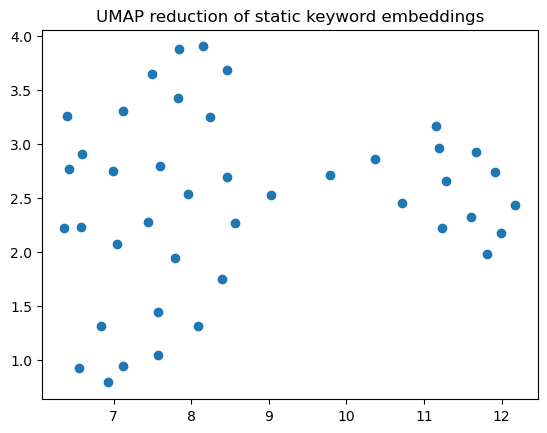

In [89]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.title('UMAP reduction of static keyword embeddings')

In [90]:
hdb = HDBSCAN()
hdb.fit(embedding)

HDBSCAN()

Text(0.5, 1.0, 'HDSCAN clustering on UMAP reduction of static keyword embeddings')

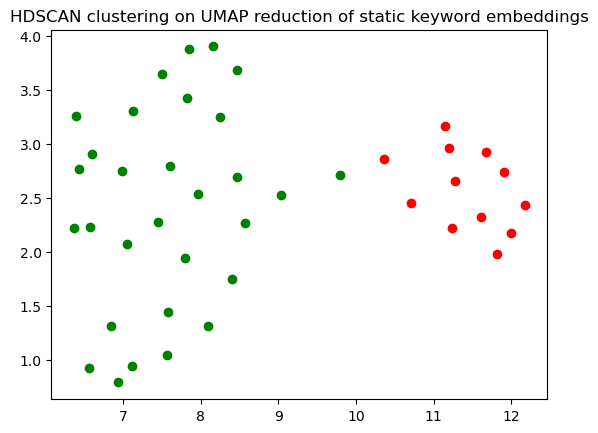

In [92]:
fig, ax = plt.subplots(1, 1)
for elt, label in zip(embedding, hdb.labels_):
    ax.scatter(elt[0], elt[1], color=colors[label])
plt.title('HDSCAN clustering on UMAP reduction of static keyword embeddings')

###### Cluster generalizations

In [93]:
static_cluster_membership = pd.DataFrame({'keyword': static_context_tokens, 'cluster': hdb.labels_})

In [94]:
static_cluster_membership[static_cluster_membership['cluster'] == 0]

,keyword,cluster
0,Limnology,0
3,Parasitology,0
13,Geology,0
17,Agronomy,0
18,Mycology,0
19,Horticulture,0
29,Gerontology,0
32,Zoology,0
34,Oceanography,0
36,Paleontology,0


In [95]:
static_cluster_membership[static_cluster_membership['cluster'] == 1]

,keyword,cluster
1,Chemistry,1
2,Immunology,1
4,Optics,1
5,Neurosciences,1
6,Psychology,1
7,Ophthalmology,1
8,Physics,1
9,Engineering,1
10,Hematology,1
11,Forestry,1


######
In contrast to the dynamic keywords, there are two clear clusters, no outliers, and both clusters are just disciplines -- because this is how the journals are classified. The clustering method once again doesn't really work; there are disciplines in both clusters I would choose to keep if I were classifying them manually. However, I think it was very worthwhile doing this analysis to get a sense of what both kinds of keywords look like, and also to justify spending the time manually classifying them.

Important to remember is the fact that we only did this analysis for unigrams; however, I don't think the results justify going back to expand it to all of the keywords.